In [1]:
# Import glob to parse filenames
import glob

# Import numpy
import numpy as np

# Plot
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,10]

# Opencv
import cv2

from tqdm import tqdm
import natsort
import os

In [2]:

img_dir = 'D:/cutmixImage/image/*.*'
img_fileList = glob.glob(img_dir)

saveDir = 'D:/cutmixImage/result/'

replaceFile = []

for i in range(len(img_fileList)):
    replaceFile.append(img_fileList[i].replace('\\','/'))

print(len(replaceFile))

342


In [ ]:
dir = 'D:/cutmixImage/image/'
NameList = []
fileList = os.listdir(dir)
sortList = natsort.natsorted(fileList)


print(sortList)
for temp in fileList:
    temp = fileList[0].split('_')
    NameList.append(temp[0])

len(NameList), NameList[:20]

In [4]:
backDir = 'D:/cutmixImage/background/*.*'
backList = glob.glob(backDir)
BackReplaceDir = []

for i in range(len(backList)):
    BackReplaceDir.append(backList[i].replace('\\','/'))

print(len(BackReplaceDir))

3


In [5]:
def reSize(ImageList):
    plus = []

    for temp in ImageList:
        bg = cv2.imread(temp, cv2.COLOR_BGR2RGB)
        #이미지 확장 코드
        plus_bg = cv2.resize(bg, (2988,2988),interpolation=cv2.INTER_CUBIC)

        re_bg = cv2.cvtColor(plus_bg, cv2.COLOR_RGB2BGR)
        plus.append(re_bg)

    return plus

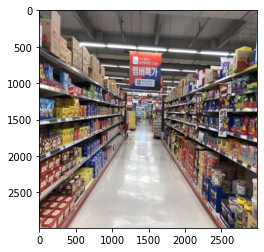

In [6]:
PlusBgList = reSize(BackReplaceDir)
plt.imshow(PlusBgList[0])
plt.show()

In [7]:
image_batch = []
for i in tqdm(range(len(replaceFile))):
    temp = cv2.imread(replaceFile[i], cv2.IMREAD_COLOR)
    img = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
    image_batch.append(img)

image_batch = np.array(image_batch)

100%|██████████| 342/342 [00:23<00:00, 14.38it/s]


In [8]:
len(image_batch)

342

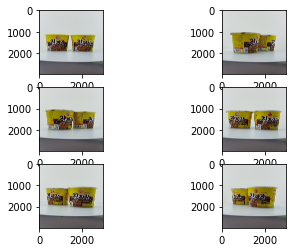

In [9]:
# 이미지 확인 
for i in range(3):
    for j in range(2):
        plt.subplot(3,2,2*i+j+1)
        plt.imshow(image_batch[2*i+j])
plt.show()

In [28]:
#이미지 4분할해서 하기
def Division2Box(size):

    W = size[0]
    H = size[1]

    cut_W = W // 2
    cut_H = H // 2

    bbox= [0,0,0,0]
    #random으로 위치 지정
    quad = np.random.randint(1,4)
    # 1사분면
    if quad == 1:
        bbox[0] = 0
        bbox[1] = 0
        bbox[2] = cut_W
        bbox[3] = cut_H
    # 2사분면
    elif quad ==2:
        bbox[0] = cut_W
        bbox[1] = 0
        bbox[2] = W
        bbox[3] = cut_H

    # 3사분면
    elif quad == 3:
        bbox[0] = 0
        bbox[1] = cut_W
        bbox[2] = cut_W
        bbox[3] = H

    # 4사분면
    elif quad == 4:
        bbox[0] = cut_W
        bbox[1] = cut_H
        bbox[2] = W
        bbox[3] = H
    

    return bbox[0],bbox[1],bbox[2],bbox[3]



In [10]:
def rand_bbox(size):
    """ 
   
    """
    # W,H : 일정 비율로 random하게 지정
    W = size[0]
    H = size[1]
    ratio = 2#np.random.randint(2,5) # W,H 비율 지정 2~5 
    cut_W = size[0] // ratio
    cut_H = size[1] // ratio

    #bounding box할 영역 / 좌상단 좌표
    bbx1 = np.random.randint(cut_W)
    bby1 = np.random.randint(cut_H)

    if bbx1 + cut_W >=W or bby1 + cut_H >=H :
        bbx2 = bbx1 - cut_W
        bby2 = bby1 - cut_H
    else:
        bbx2 = bbx1 + cut_W
        bby2 = bby1 + cut_H


    return bbx1, bby1, bbx2, bby2

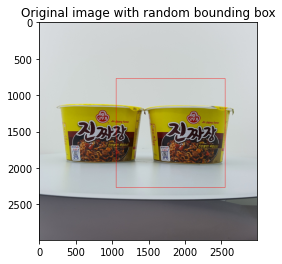

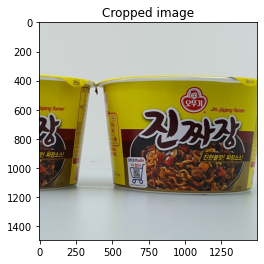

In [11]:
# Read an image
image = cv2.cvtColor(cv2.imread(replaceFile[0]), cv2.COLOR_BGR2RGB)

# Crop a random bounding box
lamb = 0.3
size = image.shape
#bbox = rand_bbox(size, lamb)
bbox = rand_bbox(size)

# Draw bounding box on the image
im = image.copy()
x1 = bbox[0]
y1 = bbox[1]
x2 = bbox[2]
y2 = bbox[3]
cv2.rectangle(im, (x1, y1), (x2, y2), (255, 0, 0), 3)
plt.imshow(im);
plt.title('Original image with random bounding box')
plt.show()

# Show cropped image
plt.imshow(image[y1:y2, x1:x2]);
plt.title('Cropped image')
plt.show()

In [34]:
def CutmixAndSave(image_batch, backImgList, Random=True):
    """
    image_batch: 라면 이미지
    backImgList: background 이미지

    return: image_batch에 background 이미지가 들어간 최종 cutmix한 이미지 
    """

    image_batch_updated = image_batch.copy()
    
    bg_len = len(backImgList)
    for i in tqdm(range(len(image_batch_updated))):
        if Random:
            bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0].shape)
        else:
            bbx1, bby1, bbx2, bby2 = Division2Box(image_batch[0].shape)
        
        bg_index = np.random.randint(bg_len) # background image random으로 하기 위해 index 지정

        image_batch_updated[i, bbx1:bbx2, bby1:bby2, :] = backImgList[bg_index][bbx1:bbx2, bby1:bby2, :]
   
   
   # sample로 결과 확인
    for i in range(3):
        for j in range(2):
            plt.subplot(3,2,2*i+j+1)
            plt.imshow(image_batch_updated[2*i+j])
            
            plt.show()
    
    # cutmix 적용한 이미지 저장
    for i, cutmix in tqdm(enumerate(image_batch_updated)):
        cv2.imwrite(saveDir+NameList[i]+'_'+str(i)+'.jpg', cv2.cvtColor(cutmix, cv2.COLOR_RGB2BGR))



In [ ]:
CutmixAndSave(image_batch,PlusBgList,False)